# Pretrain on unlabeled data

### Generate Text without training

In [45]:
import torch

from gpt2_v1 import load_model, complete_text, text_to_tensor

start_context = "at the start of"
model = load_model()
print(complete_text(start_context, model,10))

at the start of damsiman Byeodintendent typo Immun juraiden considered


In [46]:
from gpt2_v1 import dataloader_v1

with open("world_war_ii.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = dataloader_v1(raw_text,batch_size=2, context_size=4,stride=1)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("shape of input: ",inputs.shape)
print("first step, input: \n", inputs,"\n targets: \n", targets)

shape of input:  torch.Size([2, 4])
first step, input: 
 tensor([[10603,  1810,   314,   393],
        [ 1810,   314,   393,   262]]) 
 targets: 
 tensor([[1810,  314,  393,  262],
        [ 314,  393,  262, 3274]])


In [47]:
from gpt2_v1 import tensor_to_text,build_tokenizer
tokenizer = build_tokenizer()
for i in range(inputs.size(0)):
    text = tensor_to_text(inputs[i].unsqueeze(0), tokenizer)
    print(f"Input {i}: {text}")

for i in range(targets.size(0)):
    text = tensor_to_text(targets[i].unsqueeze(0), tokenizer)
    print(f"target {i}: {text}")

Input 0: World War I or
Input 1:  War I or the
target 0:  War I or the
target 1:  I or the First


In [48]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print("shape of logits: ",logits.shape)
print("shape of probas: ",probas.shape)

shape of logits:  torch.Size([2, 4, 50257])
shape of probas:  torch.Size([2, 4, 50257])


In [49]:
output_token_ids = torch.argmax(probas, dim=-1) # Replace probas with logits yield same result
print("shape of output_token_ids: ",output_token_ids.shape)
print("output_token_ids: \n",output_token_ids)

for i in range(output_token_ids.size(0)):
    text = tensor_to_text(output_token_ids[i].unsqueeze(0), tokenizer)
    print(f"output {i}: {text}")

shape of output_token_ids:  torch.Size([2, 4])
output_token_ids: 
 tensor([[38491,  2448, 36069, 24862],
        [36397, 15489, 10460, 18747]])
output 0:  constants Per Rebels myriad
output 1:  Gathering bay 800array


### Loss: Cross-Entropy and Perplexity

In [50]:
print("shape of probas: ",probas.shape)
print("shape of targets: ",targets.shape)
print(targets)


shape of probas:  torch.Size([2, 4, 50257])
shape of targets:  torch.Size([2, 4])
tensor([[1810,  314,  393,  262],
        [ 314,  393,  262, 3274]])


In [51]:
batch_size, seq_len = targets.shape
target_probas = torch.empty(batch_size, seq_len)

for text_idx in range(batch_size):
    positions = torch.arange(seq_len)
    print("targets: ", targets[text_idx])
    #same as probas[0,[0,1,2,3],[1810,  314,  393,  262]], advanced indexing
    target_probas[text_idx] = probas[text_idx, positions, targets[text_idx]]
    print(f"Text {text_idx + 1} target_probas:", target_probas[text_idx])

targets:  tensor([1810,  314,  393,  262])
Text 1 target_probas: tensor([9.9453e-06, 1.9495e-05, 1.4662e-05, 1.8303e-05])
targets:  tensor([ 314,  393,  262, 3274])
Text 2 target_probas: tensor([1.6926e-05, 2.1331e-05, 1.0184e-05, 1.8939e-05])


#### Cross Entropy Loss

For a single classification sample, assume:

- True label (one-hot):
  $$\mathbf{y} = (y_1, y_2, \dots, y_C), \quad y_i \in \{0, 1\}$$

- Predicted probabilities:
  $$\hat{\mathbf{y}} = (\hat{y}_1, \hat{y}_2, \dots, \hat{y}_C), \quad \sum_{i=1}^C \hat{y}_i = 1$$

---

#### Cross Entropy Loss (General Form)

$$
\mathcal{L}(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{i=1}^C y_i \log(\hat{y}_i)
$$

If the true class is \(k\), the formula simplifies to:

$$
\mathcal{L} = - \log(\hat{y}_k)
$$

---

#### Cross Entropy Over a Batch of \(N\) Samples

$$
\mathcal{L}_{\text{batch}} = - \frac{1}{N} \sum_{n=1}^N \sum_{i=1}^C y_i^{(n)} \log \left( \hat{y}_i^{(n)} \right)
$$


In [52]:
neg_log_probas = torch.log(target_probas) * -1
print("loss matrix: ",neg_log_probas)
loss = torch.mean(neg_log_probas)
print("loss: ",loss)

loss matrix:  tensor([[11.5184, 10.8454, 11.1303, 10.9084],
        [10.9867, 10.7553, 11.4947, 10.8743]])
loss:  tensor(11.0642)


In [53]:
print("shape of inputs: ",logits.shape) #(batch_size, seq_len, vocab_size)
print("shape of targets: ",targets.shape)
print("targets: \n",targets) #(batch_size, seq_len)
# inputs must be raw logits (unnormalized scores), NOT probabilities
# inputs shape: (batch_size * seq_len, vocab_size)
# targets shape: (batch_size * seq_len,), containing class indices
loss = torch.nn.functional.cross_entropy(logits.view(-1,logits.size(-1)), targets.view(-1))
print("loss: ",loss)

shape of inputs:  torch.Size([2, 4, 50257])
shape of targets:  torch.Size([2, 4])
targets: 
 tensor([[1810,  314,  393,  262],
        [ 314,  393,  262, 3274]])
loss:  tensor(11.0642)


#### Perplexity

Given the average cross entropy loss \(\mathcal{L}\) defined as:

$$
\mathcal{L} = - \frac{1}{N} \sum_{i=1}^N \log P(w_i)
$$

The **perplexity** is computed by exponentiating the loss:

$$
\mathrm{Perplexity} = e^{\mathcal{L}}
$$

Perplexity can indeed be larger than the vocabulary size, though usually it’s not.


In [54]:
perplexity = torch.exp(loss)
#Note perplexity is larger than vocab_size, which is expected, since the model is not trained yet.
print("perplexity: ",perplexity)

perplexity:  tensor(63842.8828)


### Losses on the training and validation sets


In [55]:
# If you didn't clean the empty lines, LLM may learn to add too many blanks.
def clean_text_remove_empty_lines(text: str) -> str:
    lines = text.splitlines()
    non_empty_lines = [line.strip() for line in lines if line.strip() != ""]
    return "\n".join(non_empty_lines)

with open("world_war_ii.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
cleaned_text = clean_text_remove_empty_lines(raw_text)

print(cleaned_text[:200])
tokens = tokenizer.encode(cleaned_text)
print("Characters: ",len(cleaned_text))
print("Tokens: ",len(tokens))

World War I or the First World War (28 July 1914 – 11 November 1918), also known as the Great War, was a global conflict between two coalitions: the Allies (or Entente) and the Central Powers. Fightin
Characters:  88775
Tokens:  18134


In [56]:
from gpt2_v1 import GPT_CONFIG_124M

# Split text data into training and validation sets
train_ratio = 0.8
split_idx = int(len(cleaned_text) * train_ratio)
train_data, val_data = cleaned_text[:split_idx], cleaned_text[split_idx:]
print("Train data: ", len(train_data))
print("Val data: ", len(val_data))

torch.manual_seed(123)
train_loader = dataloader_v1(
    train_data, batch_size=2,
    context_size=128,
    stride=128,
    drop_last=True, shuffle=True)
val_loader = dataloader_v1(
    val_data, batch_size=2,
    context_size=128,
    stride=128,
    drop_last=False, shuffle=False)


Train data:  71020
Val data:  17755


In [57]:
print("Train dataloader: ", len(train_loader))
train_first_batch = next(iter(train_loader))
print(train_first_batch[0].shape, train_first_batch[1].shape)
print("Val dataloader: ", len(val_loader))
val_first_batch = next(iter(val_loader))
print(val_first_batch[0].shape, val_first_batch[1].shape)


Train dataloader:  56
torch.Size([2, 128]) torch.Size([2, 128])
Val dataloader:  14
torch.Size([2, 128]) torch.Size([2, 128])


In [58]:
def loss_batch(inputs, targets, model, device):
    inputs, targets = inputs.to(device), targets.to(device)
    logits = model(inputs)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), targets.flatten(0))
    return loss


def loss_loader(loader, model, device, num_batches=None):
    if len(loader) == 0:
        return float('nan')

    total_loss = 0.0
    # num_batches no more than len(loader), default to len(loader)
    num_batches = min(num_batches or len(loader), len(loader))

    for i, (inputs, targets) in enumerate(loader):
        if i >= num_batches:
            break
        loss = loss_batch(inputs, targets, model, device)
        total_loss += loss.item()

    return total_loss / num_batches

In [59]:
# MPS may have some issues when training
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)

model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = loss_loader(train_loader, model, device)
    val_loss = loss_loader(val_loader, model, device)
print("Train loss: ", train_loss)
print("Val loss: ", val_loss)

Train loss:  10.997474551200867
Val loss:  10.991527489253453


### Train

In [60]:

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, tokens_seen_track = [], [], []
    tokens_seen, step = 0, 0

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            step += 1

            if step % eval_freq == 0:
                train_loss = loss_loader(train_loader, model, device, eval_iter)
                val_loss = loss_loader(val_loader, model, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                tokens_seen_track.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(model, tokenizer, start_context, device)

    return train_losses, val_losses, tokens_seen_track


def generate_and_print_sample(model, tokenizer, start_context, device):
    model.eval()
    with torch.no_grad():
        result = complete_text(start_context, model,20,GPT_CONFIG_124M,device)
        print(result)
    model.train()


In [61]:
import copy
from gpt2_v1 import GPT2Model
import time

config = copy.deepcopy(GPT_CONFIG_124M)
config["context_length"] = 128

# Set seed for reproducibility
torch.manual_seed(123)
# Initialize model and optimizer
model = GPT2Model(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)

# Start timer
start_time = time.time()

# Train the model
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=10,
    eval_iter=5,
    start_context="at the start of",
    tokenizer=tokenizer
)

# Report execution time
elapsed = (time.time() - start_time) / 60
print(f"Training completed in {elapsed:.2f} minutes.")


Ep 1 (Step 000010): Train loss 8.104, Val loss 8.263
Ep 1 (Step 000020): Train loss 7.535, Val loss 7.935
Ep 1 (Step 000030): Train loss 7.153, Val loss 7.773
Ep 1 (Step 000040): Train loss 6.801, Val loss 7.731
Ep 1 (Step 000050): Train loss 6.626, Val loss 7.619
at the start of the war.
 of the war.
 and the war, the war, the war, and
Ep 2 (Step 000060): Train loss 6.402, Val loss 7.679
Ep 2 (Step 000070): Train loss 6.217, Val loss 7.721
Ep 2 (Step 000080): Train loss 6.105, Val loss 7.633
Ep 2 (Step 000090): Train loss 6.103, Val loss 7.612
Ep 2 (Step 000100): Train loss 5.734, Val loss 7.622
Ep 2 (Step 000110): Train loss 5.926, Val loss 7.556
at the start of the war.
===
===
===
===
===
===
==== war.

Ep 3 (Step 000120): Train loss 5.407, Val loss 7.646
Ep 3 (Step 000130): Train loss 5.406, Val loss 7.719
Ep 3 (Step 000140): Train loss 5.118, Val loss 7.606
Ep 3 (Step 000150): Train loss 4.908, Val loss 7.610
Ep 3 (Step 000160): Train loss 4.632, Val loss 7.425
at the start of th

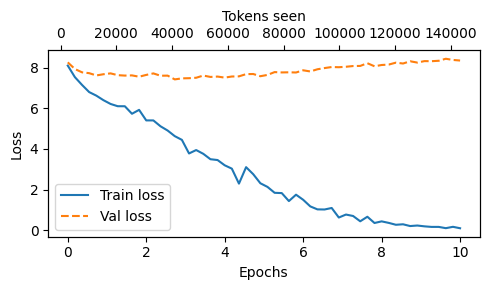

In [62]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs, tokens, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs, train_losses, label="Train loss")
    ax1.plot(epochs, val_losses, linestyle="--", label="Val loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    # plt.savefig("loss-plot.pdf")
    plt.show()

# Example usage
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


### Decoding Strategies to control randomness

#### Sample decoding:
- Greedy decoding: Select the word with the highest probability (argmax) at each step.

- Sampling decoding: Randomly sample the next word from the probability distribution, for example using torch.multinomial.

In [121]:
model.eval()
result = complete_text("At the start of the", model,15,device="cpu")
print("Output text:\n", result)


Output text:
 At the start of the Treaty of Bucharest was formally annulled by the Armistice of


In [123]:
import torch

input_text = "At the start of the"
input_tensor = text_to_tensor(input_text, tokenizer).to("cpu")
print("Input tensor: ", input_tensor)

logits = model(input_tensor)
print("Shape of logits: ", logits.shape)

next_token_logits = logits[:, -1, :]
print("Shape of next_token_logits: ", next_token_logits.shape)
print("next_token_logits: ", next_token_logits)

probas = torch.softmax(next_token_logits, dim=-1)
next_token_id = torch.argmax(probas, dim=-1).item()
print("Next token id: ", next_token_id)

next_token = tokenizer.decode([next_token_id])
print("Next token: ", next_token)

Input tensor:  tensor([[2953,  262,  923,  286,  262]])
Shape of logits:  torch.Size([1, 5, 50257])
Shape of next_token_logits:  torch.Size([1, 50257])
next_token_logits:  tensor([[-2.1345, -0.8003, -6.3171,  ..., -6.6543, -5.5982, -6.4263]],
       grad_fn=<SliceBackward0>)
Next token id:  21345
Next token:   Treaty


In [124]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print("Next token id: ", next_token_id)
next_token = tokenizer.decode([next_token_id])
print("Next token: ", next_token)

Next token id:  4141
Next token:   French


In [66]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(100)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=probas.shape[-1])
    for id, freq in enumerate(sampled_ids):
        if freq > 1:
            print(f"{freq} x {tokenizer.decode([id])}")

print_sampled_tokens(probas)


3 x  end
2 x  war
2 x  policy
2 x  British
2 x  meaning
22 x  French
2 x  direction
2 x  refused
3 x  Empire
28 x  Treaty


In [67]:
import torch

#Complete 'At the start of the'
possible_text = "war battle revolution novel experiment day journey movement"
words = possible_text.lower().split()
vocab = {word: idx for idx, word in enumerate(words)}
inverse_vocab = {idx: word for word, idx in vocab.items()}

# Step 2: Generate random logits for each vocab token
vocab_size = len(vocab)
torch.manual_seed(123)
next_token_logits = torch.normal(mean=0.0, std=4.0, size=(vocab_size,))  # increase std to increase randomness

# Convert logits to probabilities
probas = torch.softmax(next_token_logits, dim=0)

# Pick next token by argmax
next_token_id = torch.argmax(probas).item()

# Decode and print the predicted token
print(f"Next generated token: {inverse_vocab[next_token_id]}")


Next generated token: day


In [68]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(100)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=probas.shape[-1])
    for id, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[id]}")

print_sampled_tokens(probas)


11 x war
31 x battle
7 x revolution
4 x novel
0 x experiment
46 x day
1 x journey
0 x movement


#### Temperature

In [69]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

# Temperature values
temperatures = [1.0, 0.3, 1.5]

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

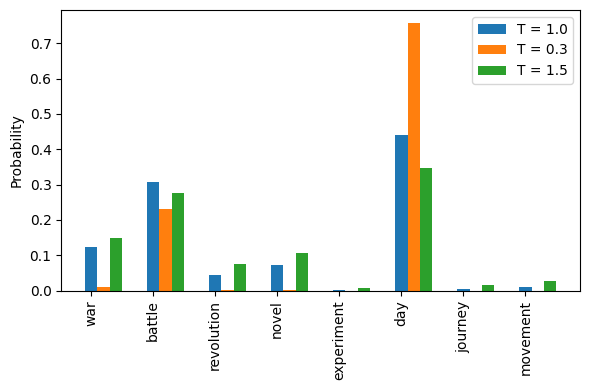

In [70]:
import torch
import matplotlib.pyplot as plt

# Plotting
x = torch.arange(len(vocab))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(6, 4))

for i, T in enumerate(temperatures):
    ax.bar(x + i * bar_width, scaled_probas[i], width=bar_width, label=f"T = {T}")

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


#### top-k Sampling

In [71]:
print(next_token_logits)
top_k = 3
top_k_logits, top_k_indices = torch.topk(next_token_logits, k=top_k, dim=-1)
print("top_k_logits: ", top_k_logits)
print("top_k_indices: ", top_k_indices)

tensor([-0.4459,  0.4815, -1.4785, -0.9617, -4.7877,  0.8371, -3.8894, -3.0202])
top_k_logits:  tensor([ 0.8371,  0.4815, -0.4459])
top_k_indices:  tensor([5, 1, 0])


In [72]:
# Mask out logits that are not in the top-k by setting them to -inf
threshold = top_k_logits[-1]
new_logits = torch.where(
    next_token_logits < threshold,
    torch.full_like(next_token_logits, float('-inf')),
    next_token_logits
)

print("new_logits: ", new_logits)
topk_probas = torch.softmax(new_logits, dim=-1)
print("topk_probas: ", topk_probas)

print_sampled_tokens(topk_probas)

new_logits:  tensor([-0.4459,  0.4815,    -inf,    -inf,    -inf,  0.8371,    -inf,    -inf])
topk_probas:  tensor([0.1402, 0.3543, 0.0000, 0.0000, 0.0000, 0.5056, 0.0000, 0.0000])
13 x war
34 x battle
0 x revolution
0 x novel
0 x experiment
53 x day
0 x journey
0 x movement


### Generate text with temperature and top_k

In [73]:
def generate_text_simple(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        # Get logits from model
        with torch.no_grad():
            logits = model(idx_cond)

        # Take logits for the last time step
        # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k, dim=-1)  # (batch, top_k)
            threshold = top_logits[:, -1].unsqueeze(-1) # (batch, ) -> (batch, 1)
            logits = torch.where(
                logits < threshold,
                torch.full_like(logits, float('-inf')),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

            # Sample from distribution
            idx_next = torch.multinomial(probas, num_samples=1)  # (batch, 1)
        else:
            # Greedy sampling
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        if eos_id is not None and idx_next == eos_id:
            break

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [133]:
torch.manual_seed(123)

token_ids = generate_text_simple(
    model=model.to("cpu"),
    idx=text_to_tensor("at the start of the", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=3,
    temperature=1.4
)

print("Output text:\n", tensor_to_text(token_ids, tokenizer))

Output text:
 at the start of the French troops had been unjust. On 3 November 1918 and the German leaders,


### Train on larger datasets

In [75]:
from datasets import load_dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")


In [76]:
print(dataset)


DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [77]:
train_dataset = dataset['train']
print(train_dataset['text'][:5])

val_dataset = dataset['validation']
print(val_dataset['text'][:5])

['', ' = Valkyria Chronicles III = \n', '', ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n', " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgi

In [78]:
train_data = " ".join(train_dataset['text'])
print("train_data: ", train_data[:100])

val_data = " ".join(val_dataset['text'])
print("val_data: ", val_data[:100])

train_data:    = Valkyria Chronicles III = 
   Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリ
val_data:    = Homarus gammarus = 
   Homarus gammarus , known as the European lobster or common lobster , is a


In [79]:
print(len(train_data), len(val_data))

10929707 1145909


In [80]:
print(text_to_tensor(train_data,tokenizer).shape)

torch.Size([1, 2428601])


In [81]:
print(len(train_loader), len(val_loader))
#2428601/16/128=1185

56 14


In [82]:
import torch
# from gpt2_v1 import complete_text
import time
# from gpt2_v1 import dataloader_v1, GPT2Model, GPT_CONFIG_124M, build_tokenizer

device = torch.device("mps")

train_loader = dataloader_v1(
    train_data, batch_size=16,
    context_size=256,
    stride=256,
    drop_last=True, shuffle=True)
val_loader = dataloader_v1(
    val_data, batch_size=16,
    context_size=256,
    stride=256,
    drop_last=False, shuffle=False)

# Set seed for reproducibility
torch.manual_seed(123)
torch.set_num_threads(8)
# Initialize model and optimizer
model = GPT2Model(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)

# Start timer
start_time = time.time()

# Train the model
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=300,
    eval_iter=10,
    start_context="at the start of",
    tokenizer=build_tokenizer()
)

# Report execution time
elapsed = (time.time() - start_time) / 60
print(f"Training completed in {elapsed:.2f} minutes.")


In [83]:
#300*16*128
print(model)

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=768, bias=False)
        (W_K): Linear(in_features=768, out_features=768, bias=False)
        (W_V): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Transforme

In [84]:
train_model_simple(model, train_loader, val_loader, optimizer, device,
                   num_epochs=10, eval_freq=200, eval_iter=50,
                   start_context="Once upon a time", tokenizer=tokenizer,
                   resume_path="checkpoints/checkpoint_epoch4.pth")


TypeError: train_model_simple() got an unexpected keyword argument 'resume_path'

In [29]:
from gpt2_v2 import GPT2Model, GPT_CONFIG_124M
checkpoint = torch.load("checkpoint_epoch3.pth", weights_only=True)

model = GPT2Model(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
model.to("cpu")
model.eval()

result = complete_text("at the start of", model,15)
print("Output text:\n", result)


Output text:
 at the start of the war , the first time they were defeated . 
   =
